In [18]:
# from src.dataLoader import dataLoader
# from src.utils import plot_image, get_image
import numpy as np
import cv2
from skimage import morphology,measure
%load_ext autoreload
%autoreload
from src.dataLoader import dataLoader
from src.utils import image_utils, ismember

from src.preprocessing import imadjust,imagecrop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
dataset = dataLoader("./data")
imageFileList = dataset.LoadFileList()

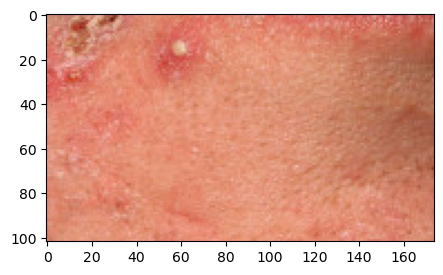

(102, 174, 3)
8.381903e-09 1.0


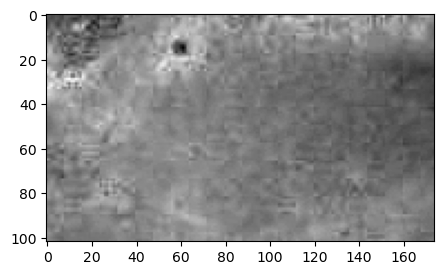

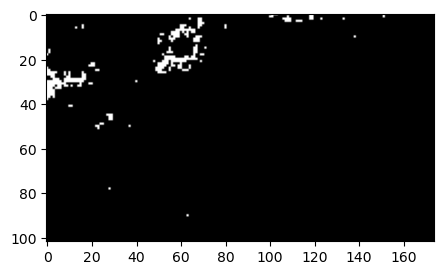

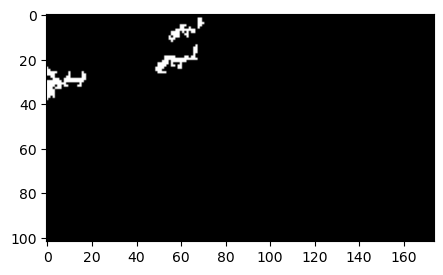

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[<skimage.measure._regionprops.RegionProperties object at 0x0000023E9CE17B48>, <skimage.measure._regionprops.RegionProperties object at 0x0000023E9CE170C8>, <skimage.measure._regionprops.RegionProperties object at 0x0000023E9CE17BC8>, <skimage.measure._regionprops.RegionProperties object at 0x0000023E9CE17108>]


AttributeError: 'list' object has no attribute 'Area'

In [21]:
for image_path in imageFileList[:2]:
    print("="*50)
    # get RGB image
    color_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2RGB, is_gray=False)
    # image cropping => boundary are unlikely to be the ROI
    color_image = imagecrop(color_image)
    image_utils().plot_image(color_image,figsize=(5,5))

    print(color_image.shape)

    # convert RGB to grey
    gray_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2GRAY, is_gray=True)
    gray_image = imagecrop(gray_image)
    # image_utils().plot_image(gray_image,figsize=(5,5))

    # normalize gray to scale (0,1) minmax
    norm_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    print(norm_image.min(), norm_image.max())

    # get image in HSV scale
    hsv_image = image_utils().get_image(image_path, image_scale=cv2.COLOR_BGR2HSV, is_gray=False)
    hsv_image = imagecrop(hsv_image)
    #  Extract Brightness component (V) from HSV image and normalize it into scale of (0,1)
    V = hsv_image[...,2]
    norm_v_image = cv2.normalize(V, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # image_utils().plot_image(norm_v_image,figsize=(5,5))

    # Subtraction for Region of Interest (ROI)
    ROI_image = (norm_v_image - norm_image)
    ROI_image = imadjust(ROI_image, ROI_image.min(), ROI_image.max(), 0,1)
    image_utils().plot_image(ROI_image,figsize=(5,5))
    
    # Thresholding convert to boolean image map
    BTh = 0.73
    binary_threshold_image = ROI_image > BTh
    image_utils().plot_image(binary_threshold_image,figsize=(5,5))

    # Removing minum and maximum areas around the image. Use the morphological
    # concept of convex component CC
    binary_threshold_image = morphology.remove_small_objects(binary_threshold_image, 10)
    image_utils().plot_image(binary_threshold_image,figsize=(5,5))
    all_labels = measure.label(binary_threshold_image)
    S = measure.regionprops(all_labels)
    print(all_labels)
    print(S)
    
    binary_threshold_image2 = ismember(all_labels, np.where([S.Area] < 50))
    image_utils().plot_image(binary_threshold_image2,figsize=(5,5))